<font size=3>In this notebook, we demonstrate using LSTM model to run prediction on the time series data. </font>

In [3]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Dense

Reading data

In [ ]:
## ALL DATA FILES FOR IDLE_WHEEL
files = [fn for fn in glob.glob('../new_threshold/idle_wheel_/**/*.csv', recursive=True)]

In [33]:
## LOADING DATA (Moving Variance)
idle_wheel_mvg_var = [pd.read_csv(file) for file in sorted(files[:7])]

## LOADING DATA (Raw Data)
idle_wheel_raw = [pd.read_csv(file) for file in sorted(files[7:])]

Preprocessing

In [39]:
def gen_data(lst):
    """
    Accepts list of files
    Reshape features
    Returns data and corresponding labels
    """
    features = []
    labels = []
    for df in lst:
        f = np.array(df.iloc[:,1:11])
        l = np.array(df.iloc[:,11].astype(int))
        features.append(f)
        labels.append(l)
        
        feature_output = np.concatenate(features)
        
    return feature_output.reshape(feature_output.shape[0], feature_output.shape[1], 1), np.concatenate(labels)
        

Train/Test set splitting + preprocess

In [66]:
x_train, y_train = gen_data(idle_wheel_mvg_var[1:])
print("Training set shape: ", x_train.shape)

x_test, y_test = gen_data([idle_wheel_mvg_var[0]])
print("Test set shape: ", x_test.shape)

Training set shape:  (8762, 10, 1)
Test set shape:  (2614, 10, 1)


Model architecture

In [44]:
model = Sequential()
model.add(LSTM(100, input_shape=(10,1)))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 51,921
Trainable params: 51,921
Non-trainable params: 0
_________________________________________________________________
None


Training

In [45]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
8762/8762 [==============================] - 5s 580us/step - loss: 0.1379
Epoch 2/10
8762/8762 [==============================] - 4s 447us/step - loss: 0.0335
Epoch 3/10
8762/8762 [==============================] - 4s 441us/step - loss: 0.0366
Epoch 4/10
8762/8762 [==============================] - 4s 443us/step - loss: 0.0313
Epoch 5/10
8762/8762 [==============================] - 4s 445us/step - loss: 0.0307
Epoch 6/10
8762/8762 [==============================] - 4s 446us/step - loss: 0.0311
Epoch 7/10
8762/8762 [==============================] - 4s 441us/step - loss: 0.0321
Epoch 8/10
8762/8762 [==============================] - 4s 439us/step - loss: 0.0373
Epoch 9/10
8762/8762 [==============================] - 4s 448us/step - loss: 0.0292
Epoch 10/10
8762/8762 [==============================] - 4s 441us/step - loss: 0.0289


In [46]:
pred_train = model.predict(x_train)
pred_train = pred_train.round()

In [47]:
def predict_plot(raw, pred, actual, title, axes):
    """
    """
    raw['realvalue'].plot(ax=axes)
    raw['Moving_variance'].plot(ax=axes)
    pd.Series(pred['pred_conc']).plot(ax=axes )
    pd.Series(actual).plot(ax=axes)
    axes.set_title('%s \n Accuracy: %f F1: %f'% (title, pred['acc'],pred['f1']) + '\n tn: %2.f fp: %2.f fn: %2.f tp: %2.f' % (pred['conf_mat'][0], pred['conf_mat'][1], pred['conf_mat'][2],pred['conf_mat'][3] ) )
    axes.legend(['raw data', 'moving variance', 'prediction', 'actual label'],loc='upper right')

In [48]:
pred_train.shape, y_train.shape

((8762, 1), (8762,))

In [49]:
y_train = y_train.reshape(-1,1)

In [50]:
(pred_train == y_train).sum()

8708

In [51]:
len(pred_train)

8762

In [52]:
pred_test = model.predict(x_test)
pred_test = pred_test.round()

(pred_test == y_test.reshape(-1,1)).sum()

2588

In [63]:
print(len(y_test))
print(len(pred_test))

2614
2624


In [64]:
l = [0 for i in range(10)]
print(l)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [56]:
pred_test = np.concatenate([np.zeros(10),pred_test.flatten()])

Predict & Evaluate

In [57]:
def predict(model, test_data, test_label):
    pred = model.predict(test_data)
    pred = pred.round()
    try:
        tn, fp, fn, tp = confusion_matrix(pred.flatten(), test_label).ravel()
    except:
        tn = 0
        fp = 0
        fn = 0
        tp = 0
    
    acc = (pred.flatten() == test_label.flatten()).sum()/ len(test_label)
    f1 = f1_score(pred, test_label)  
    pred_conc = np.concatenate([np.zeros(10),pred.flatten()])
    return {
        'pred': pred.flatten(),
        'pred_conc':pred_conc,
        'conf_mat': (tn, fp, fn, tp),
        'acc': acc,
        'f1': f1
    }
    
    
    

In [58]:
pred_1 = predict(model, x_test, y_test)

Visualisation

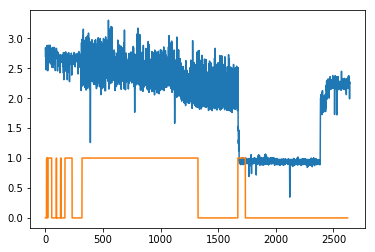

In [61]:
idle_wheel_raw[0]['realvalue'].plot()
pd.Series(pred_test).plot()

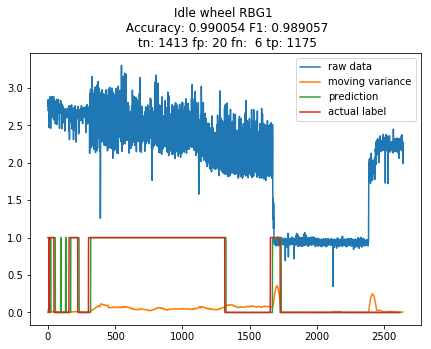

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(7,5))
predict_plot(idle_wheel_raw[0], pred_1, y_test, 'Idle wheel RBG1', axes)